In [483]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from string2string.alignment import LongestCommonSubsequence
from string2string.distance import JaccardIndex



In [586]:
generated = pd.read_csv("../data/generated_outputs.csv")
# generated = generated[temperatures].melt().rename({"variable": "temperature", "value": "text"}, axis=1)

In [587]:
original = pd.read_csv("../summaries.csv")

In [588]:
new = pd.read_csv("../data/processed_responses.csv").drop("HITId", axis=1)

In [589]:
qids = pd.read_csv("../data/qids.csv")

In [590]:
# temperatures = [str(k) for k in [0.3, 0.5, 0.7, 0.9, 1]]
temperatures = [str(k) for k in [0.7, 0.9]]

In [591]:
generated["texts"] = generated["texts"].apply(lambda x: x[4:20]).str.lower()
qids["question"] = qids["question"].apply(lambda x: x[4:20]).str.lower()

In [592]:
new["original_text"] = new["original_text"].apply(lambda x: x[4:20]).str.lower()

In [593]:
original = original[["Question", "Answer"]]

In [594]:
new = new.merge(qids, left_on="original_text", right_on="question")[["HITId","summary", "copied"]]

In [595]:
new = new[new["summary"].map(len) > 150]

In [596]:
generated = generated.merge(qids, left_on="texts", right_on="question")[["HITId"] + temperatures].melt(id_vars = "HITId").rename({"value":"generated"}, axis=1)



In [597]:
generated = generated[generated["variable"].str.contains("0.7|1")]

In [598]:
original["Answer"].map(len).mean()

1381.3046875

In [599]:
drop = [20,22, 26, 47]

In [600]:
new = new[~new.index.isin(drop)]

In [601]:
new["summary"]

0     Because carbs usually provide over half of cal...
1     A study was conducted to compare the effective...
2     This two-year study found that diets varying i...
3     Effect of Screening Mammography on Breast-Canc...
4     A study in Norway found that screening mammogr...
5     The Norwegian breast-cancer screening program ...
6     Exciting news from a study on a malaria vaccin...
7     A phase 3 study of the malaria vaccine RTS, S/...
8     A phase 3 trial of the RTS, S/AS01 malaria vac...
9     Azithromycin is a broad-spectrum macrolide ant...
10    During 5 days of therapy, patients taking azit...
11    azithromycin is an antibiotic that doctors use...
12    Sibutramine is a weight loss drug that has bee...
13    In a study of 10,744 overweight or obese subje...
15    A randomized, placebo-controlled, double-blind...
16    Exemestane is an aromatase inhibitor that has ...
17    here they discuss about the two members  Tamox...
18    The introduction of screening mammography 

In [602]:
def extract_answer(text):
    pattern = r"<FreeText>(.*?)</FreeText>"
    matches = re.findall(pattern, text, re.DOTALL)

    return matches[1]
original["Answer"] = original["Answer"].apply(lambda x: extract_answer(x))

In [603]:
def measure_subseq_length(gen, k):
#     lcsubsequence = LongestCommonSubstring()
    lcsubsequence = LongestCommonSubsequence()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

In [604]:
def measure_substr_length(gen, k):
    lcsubsequence = LongestCommonSubstring()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

In [605]:
def measure_jaccard_sim(gen, k):
#     lcsubsequence = LongestCommonSubstring()
    jaccard_distance = JaccardIndex()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    jaccard_dist_score = jaccard_distance.compute(gen_token, k_token)

    return jaccard_dist_score

In [606]:
ids = new["HITId"].unique()

In [607]:
new_sim = []
original_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["generated"]
        for j, row2 in new_.iterrows():
            summary = row2["summary"]
            new_sim.append([idx, measure_subseq_length(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_sim.append([idx, measure_subseq_length(gen_text, summary)])
        

In [608]:
new_sub_sim = []
original_sub_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["generated"]
        for j, row2 in new_.iterrows():
            summary = row2["summary"]
            new_sub_sim.append([idx, measure_substr_length(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_sub_sim.append([idx, measure_substr_length(gen_text, summary)])
        

In [609]:
new_jaccard_sim = []
original_jaccard_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["generated"]
        for j, row2 in new_.iterrows():
            summary = row2["summary"]
            new_jaccard_sim.append([idx, measure_jaccard_sim(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_jaccard_sim.append([idx, measure_jaccard_sim(gen_text, summary)])
        

In [612]:
og_sim = pd.DataFrame(original_sim)
new_sim = pd.DataFrame(new_sim)

In [616]:
new_sim["copied"] = new["copied"]

In [613]:
og_j = pd.DataFrame(original_jaccard_sim)
new_j = pd.DataFrame(new_jaccard_sim)

In [617]:
new_j["copied"] = new["copied"]

In [614]:
og_s = pd.DataFrame(original_sub_sim)
new_s = pd.DataFrame(new_sub_sim)

In [618]:
new_s["copied"] = new["copied"]

In [565]:
new_sim[1].mean()

36.256410256410255

In [566]:
og_sim[1].mean()

37.015625

Text(0.5, 0, 'Longest matching subsequence')

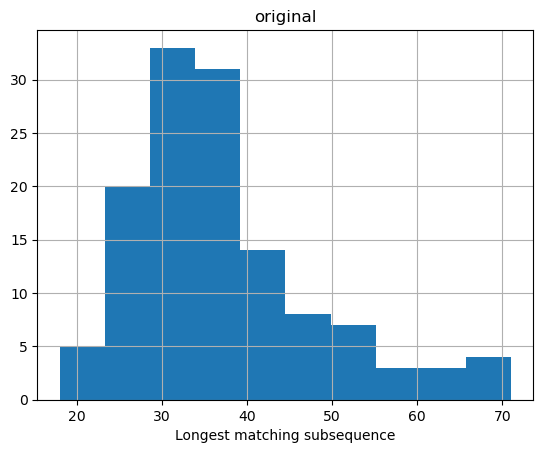

In [567]:
og_sim[og_sim[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Longest matching subsequence")

Text(0.5, 0, 'Longest matching subsequence')

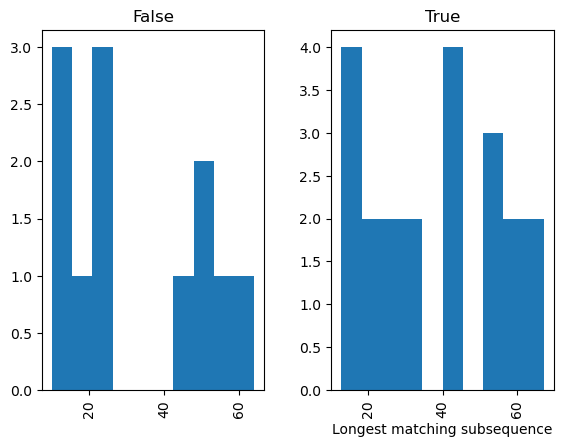

In [625]:
new_sim[new_sim[1]>0.01].rename({1: "new"}, axis=1).hist(by="copied")
plt.xlabel("Longest matching subsequence")

Text(0.5, 0, 'Jaccard')

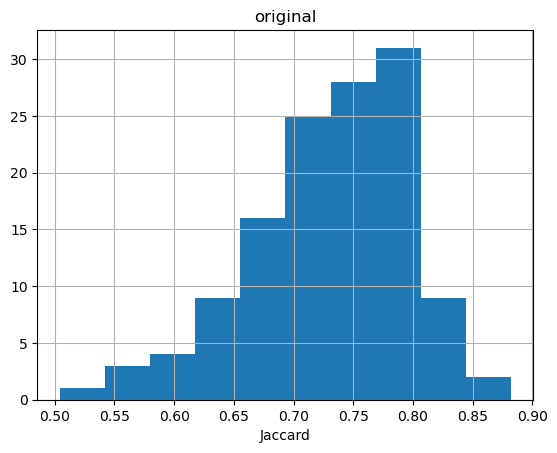

In [569]:
og_j[og_j[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Jaccard")

Text(0.5, 0, 'Jaccard')

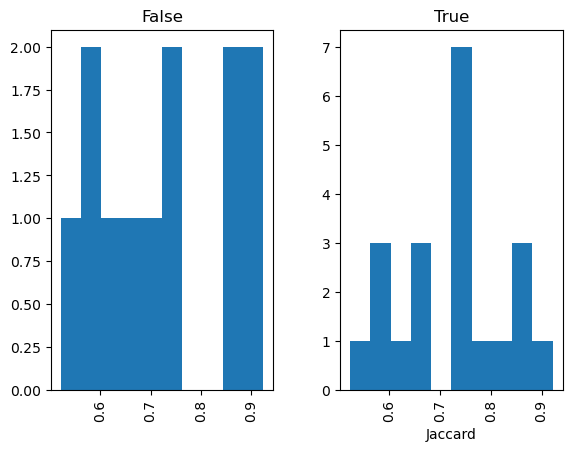

In [626]:
new_j[new_j[1]>0.01].rename({1: "new"}, axis=1).hist(by="copied")
plt.xlabel("Jaccard")

Text(0.5, 0, 'Longest matching substring')

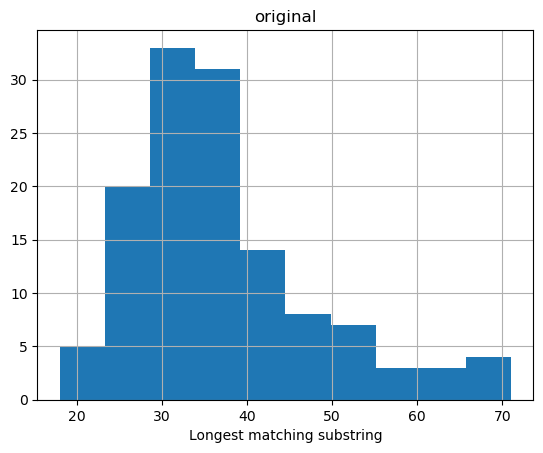

In [571]:
og_sim[og_sim[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Longest matching substring")

Text(0.5, 0, 'Longest matching substring')

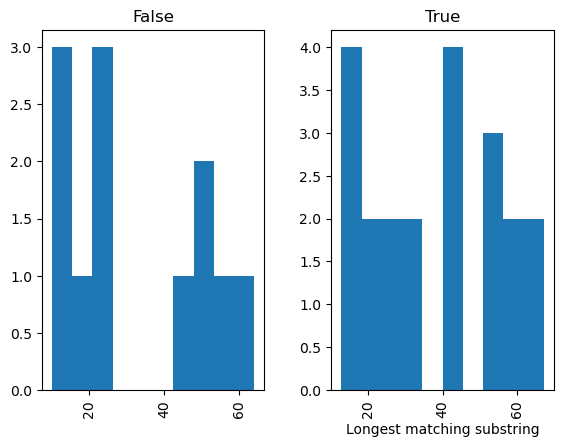

In [627]:
new_sim[new_sim[1]>0.01].rename({1: "new"}, axis=1).hist(by="copied")
plt.xlabel("Longest matching substring")